In [1]:
library("here")
library(devtools)
library(Seurat)
library(Socrates)
library(harmony)
library(RcppML)


load_all('/home/jpm73279/Socrates')
data_path <- "/scratch/jpm73279/comparative_single_cell/02.QC_clustering/Zm_proso_repeat/QC_output/"

here() starts at /home/jpm73279/Mendieta_et_al_comparative_single_cell

Loading required package: usethis

Registered S3 method overwritten by 'spatstat.geom':
  method     from
  print.boxx cli 

Attaching SeuratObject

Loading required package: cicero

Loading required package: monocle

Loading required package: Matrix

Loading required package: Biobase

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl

In [2]:
plate_1 <- paste0(data_path,"ZP_P1_G029_10x_QC_soc_obj.rds")
plate_2 <- paste0(data_path,"ZP_P2_G029_10x_QC_soc_obj.rds")
plate_3 <- paste0(data_path,"ZP_P3_G029_10x_QC_soc_obj.rds")
plate_4 <- paste0(data_path,"ZP_P11_G029_10x_QC_soc_obj.rds")




prefix <- "Uf_leaf.merged_replicates"
#PDF_dir <- "PDF_outputs"
#dir.create(PDF_dir)

rep_1_read <- readRDS(plate_1)
rep_2_read <- readRDS(plate_2)
rep_3_read <- readRDS(plate_3)
rep_4_read <- readRDS(plate_4)
rep_files <- list(rep_1_read, rep_2_read, rep_3_read, rep_4_read)
names(rep_files) <- c("ZP_P1_G029", "ZP_P2_G029", "ZP_P3_G029", "ZP_P11_G029")


print("Merging Object")
merged.obj <- mergeSocratesRDS(obj.list=rep_files)


print("Generating Socrates Obj")
    ## Generate Socrates Object
soc.obj <- merged.obj




[1] "Merging Object"
[1] "Generating Socrates Obj"


In [3]:
    print("Generating Graphs")
    # estimate log10 number of accessible regions per cell
    cell.counts <- Matrix::colSums(soc.obj$counts)

    # estimate peak accessibility frequency across cells
    site.freq <- Matrix::rowMeans(soc.obj$counts)

[1] "Generating Graphs"


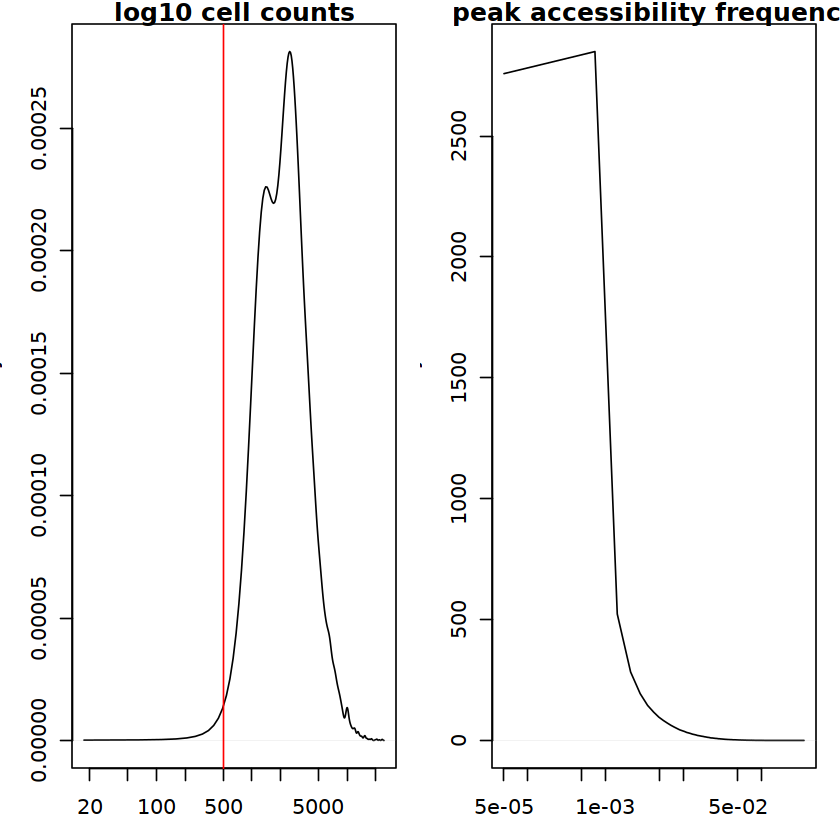

In [4]:
layout(matrix(c(1:2), ncol=2))
par(mar=c(3,3,1,1))
plot(density(cell.counts), main="log10 cell counts", log="x")
abline(v=500, col="red")
plot(density(site.freq), main="peak accessibility frequency", log="x")

In [5]:
# get per cell feature counts --------------------------------------------
cell.counts <- Matrix::colSums(soc.obj$counts)  # count number of features with Tn5 insertions per cell
cell.counts.z <- as.numeric(scale(cell.counts)) # convert features counts into Z-scores
cell.counts.threshold <- max(c(cell.counts[cell.counts.z < -1], 100)) # minimum feature counts (greater of 1 std or 1000)


# clean sparse counts matrix ---------------------------------------------
soc.obj <- cleanData(soc.obj, 
                     min.c=0,  # minimum number of accessible features per cell
                     min.t=0,  # minimum feature frequency across cells
                     max.t=0, # maximum feature frequency across cells
                     verbose=T)


# normalize with TFIDF ---------------------------------------------------
soc.obj <- tfidf(soc.obj)

   * Input: cells = 5301 | peaks = 1222836

   * Filtered: cells = 5300 | peaks = 1222741



In [ ]:
# project with NMF -------------------------------------------------------
soc.obj.reduce_dim <- reduceDims(soc.obj,
                      method="NMF", 
                      n.pcs=25, 
                      num.var=20000,
                      svd_slotName="NMF")

In [ ]:
# reduce to 2-dimensions with UMAP ---------------------------------------
soc.obj.project_umap <- projectUMAP(soc.obj.reduce_dim, 
                       verbose=T,
                       k.near=25,
                       m.dist=0.01,
                       svd_slotName="NMF")

In [ ]:
# identify clusters using neighborhood graph -----------------------------
tfidf.obj.dob.filt.clusters <- callClusters(soc.obj.project_umap, 
                        res=.5,
                        verbose=T,
                        svd_slotName= "NMF",
                        cleanCluster=FALSE)

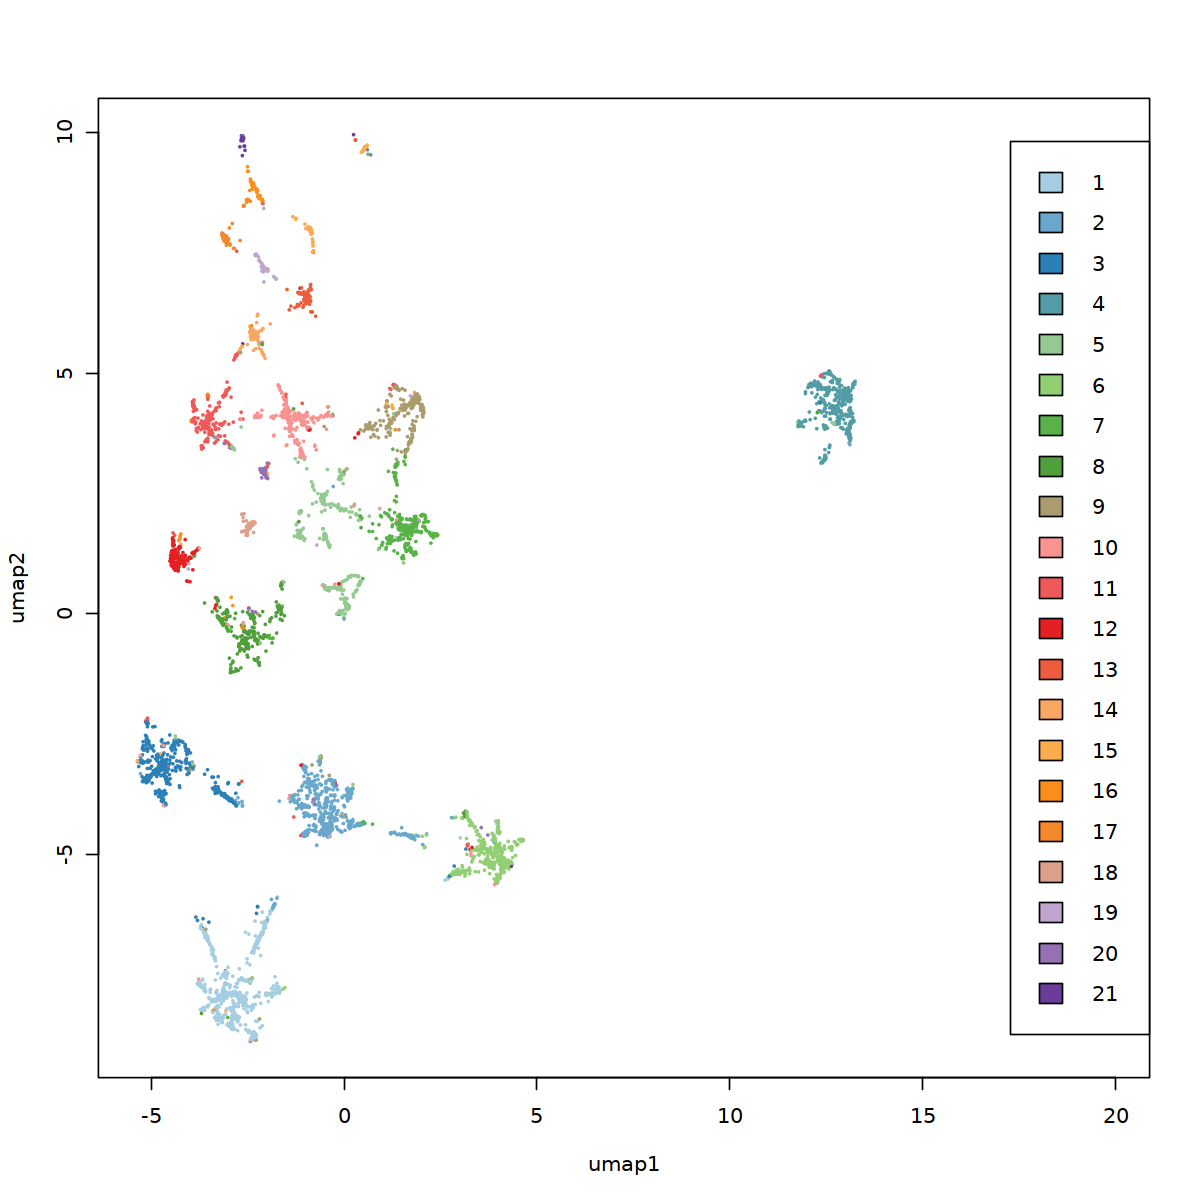

In [21]:
#plot cluster membership on UMAP embedding ------------------------------
options(repr.plot.width=10, repr.plot.height=10)
# NMF
#pdf(paste0(out,".NMF.full.UMAP.clusters.pdf"), width=10, height=10)
plotUMAP(tfidf.obj.dob.filt.clusters, cex=0.3)
#dev.off()

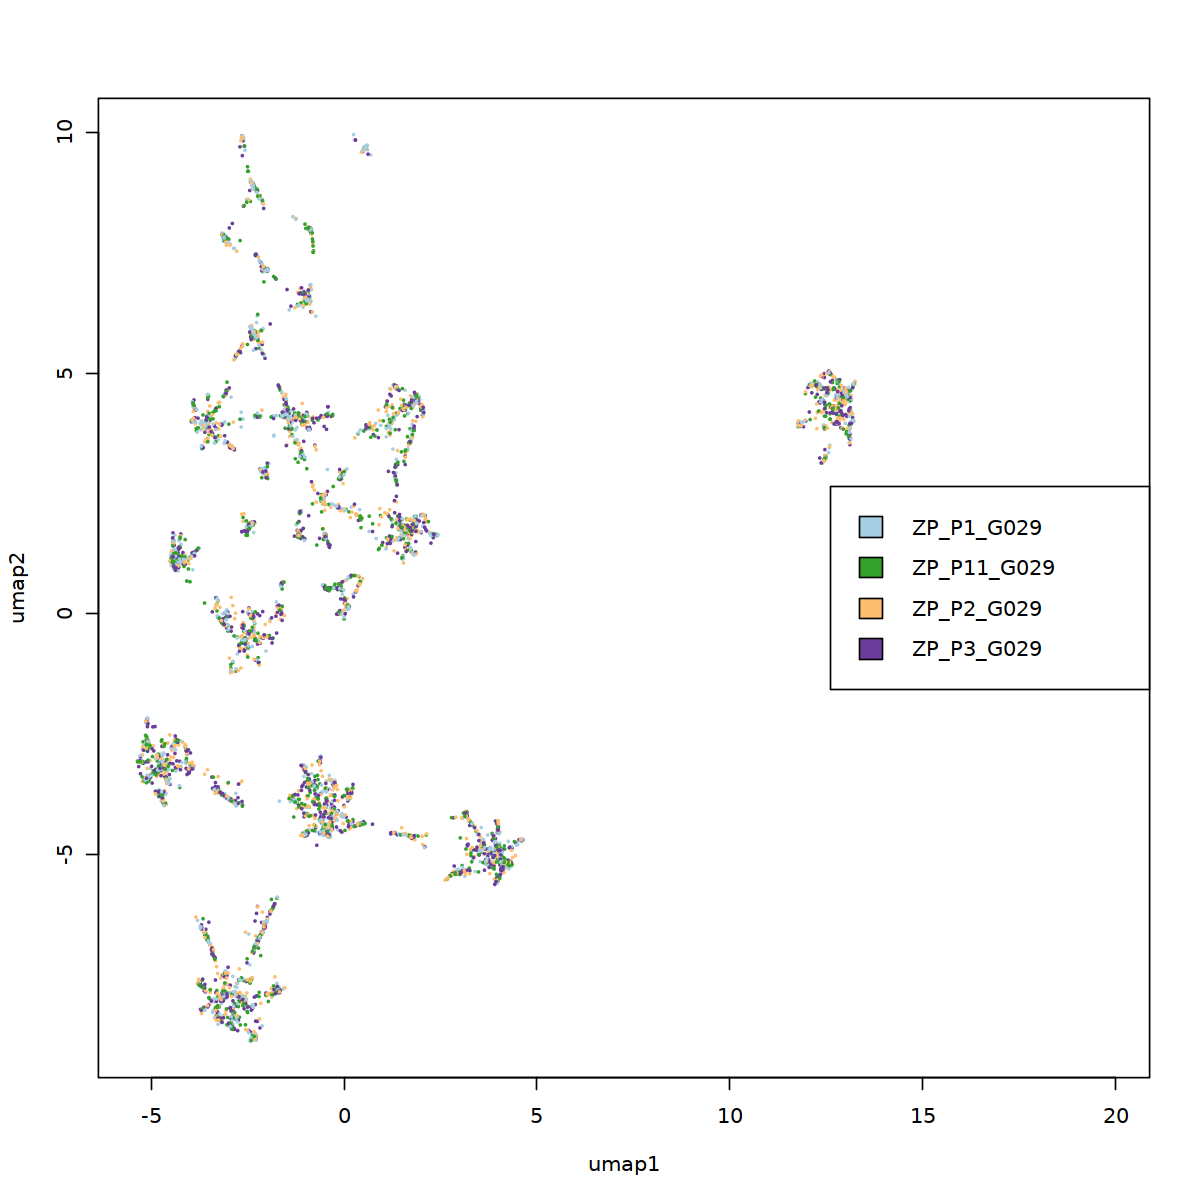

In [14]:
plotUMAP(tfidf.obj.dob.filt.clusters, cex=0.3, column = "sampleID")

In [32]:
library(dplyr)
library(tidyverse)

doublet_file_location <- "/scratch/jpm73279/comparative_single_cell/02.QC_clustering/Zm_proso_repeat/Cell_metrics.zm_proso.tsv"
collision_rate_info <- read_tsv(doublet_file_location, col_names = TRUE)

convert_meta_data <- as_tibble(tfidf.obj.dob.filt.clusters$Clusters)  %>% 
    left_join(., collision_rate_info, by = c("cellID" = "V4"))  %>% 
    filter(is.na(assigned_genome) != TRUE)


Rows: 5299 Columns: 18

── Column specification ────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (4): V4, assigned_genome, passing_bool, plate
dbl (14): total_insertions, Pm, Zm, calculate_proportion_ZM, insertions_per_...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



In [20]:
colnames(convert_meta_data)

[1] "cellID"                            "total"                            
 [3] "tss"                               "acrs"                             
 [5] "ptmt"                              "nSites"                           
 [7] "log10nSites"                       "sampleID"                         
 [9] "umap1"                             "umap2"                            
[11] "LouvainClusters"                   "total_insertions"                 
[13] "assigned_genome"                   "Pm"                               
[15] "Zm"                                "calculate_proportion_ZM"          
[17] "passing_bool"                      "plate"                            
[19] "insertions_per_peak_per_genome_Pm" "insertions_per_peak_per_genome_Zm"
[21] "per_genome_frip_Pm"                "per_genome_frip_Zm"               
[23] "mean_frip_Pm"                      "mean_frip_Zm"                     
[25] "sd_frip_Pm"                        "sd_frip_Zm"                       
[27] "final_frip_cut_off_Pm"             "final_frip_cut_off_Zm"

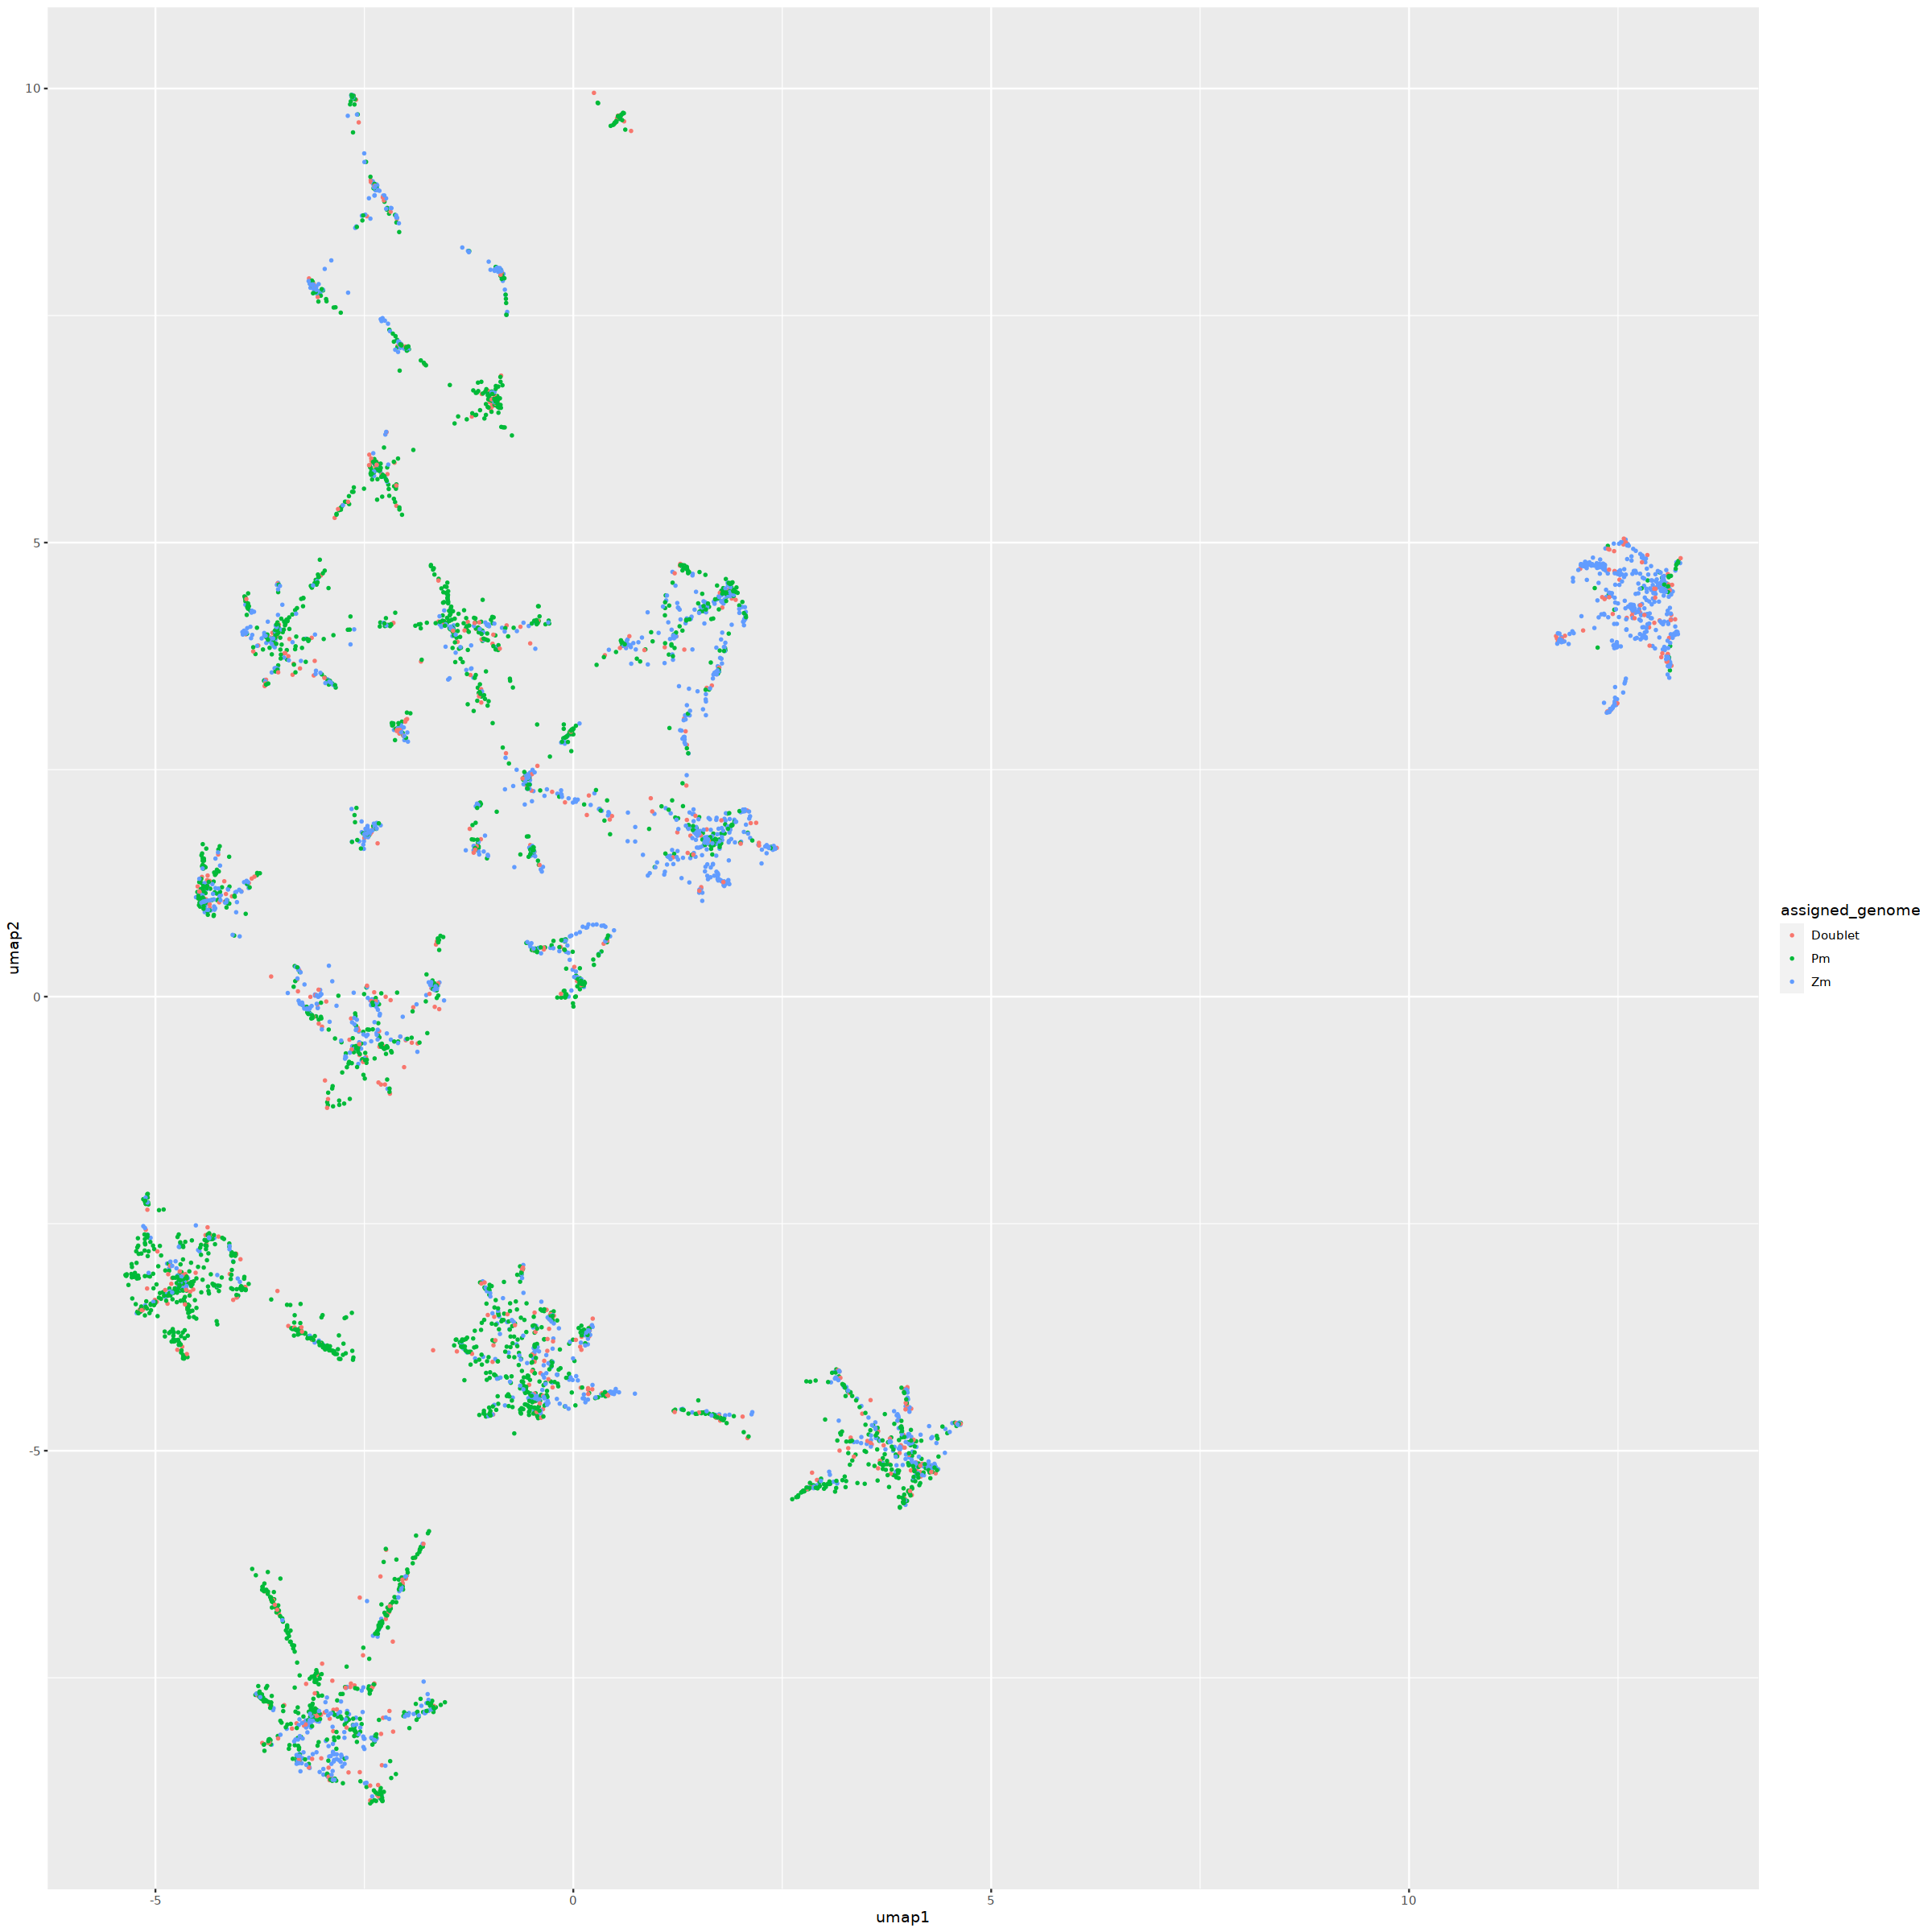

In [35]:
options(repr.plot.width=20, repr.plot.height=20)
ggplot(convert_meta_data, aes(x = umap1, y = umap2, color = assigned_genome)) + 
geom_jitter(size =.5) 

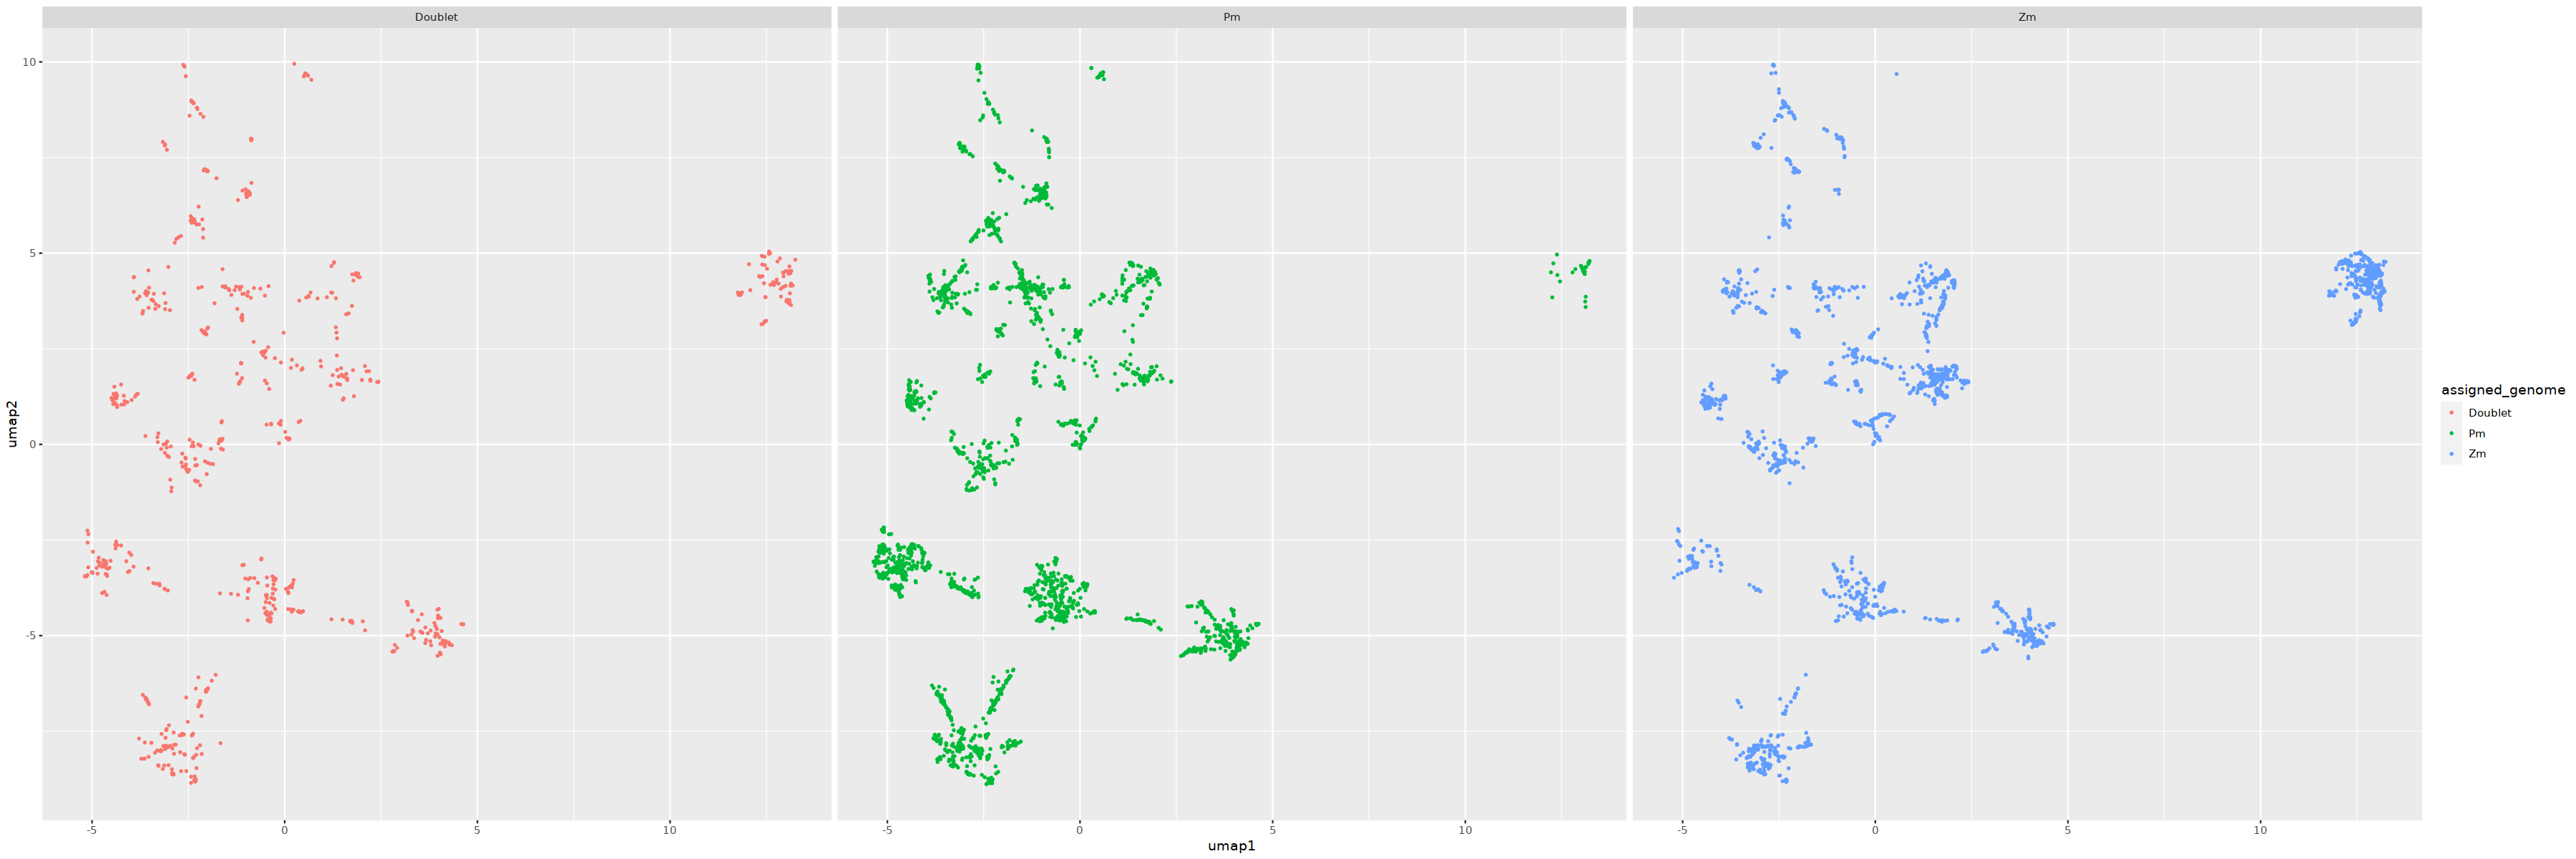

In [36]:
b

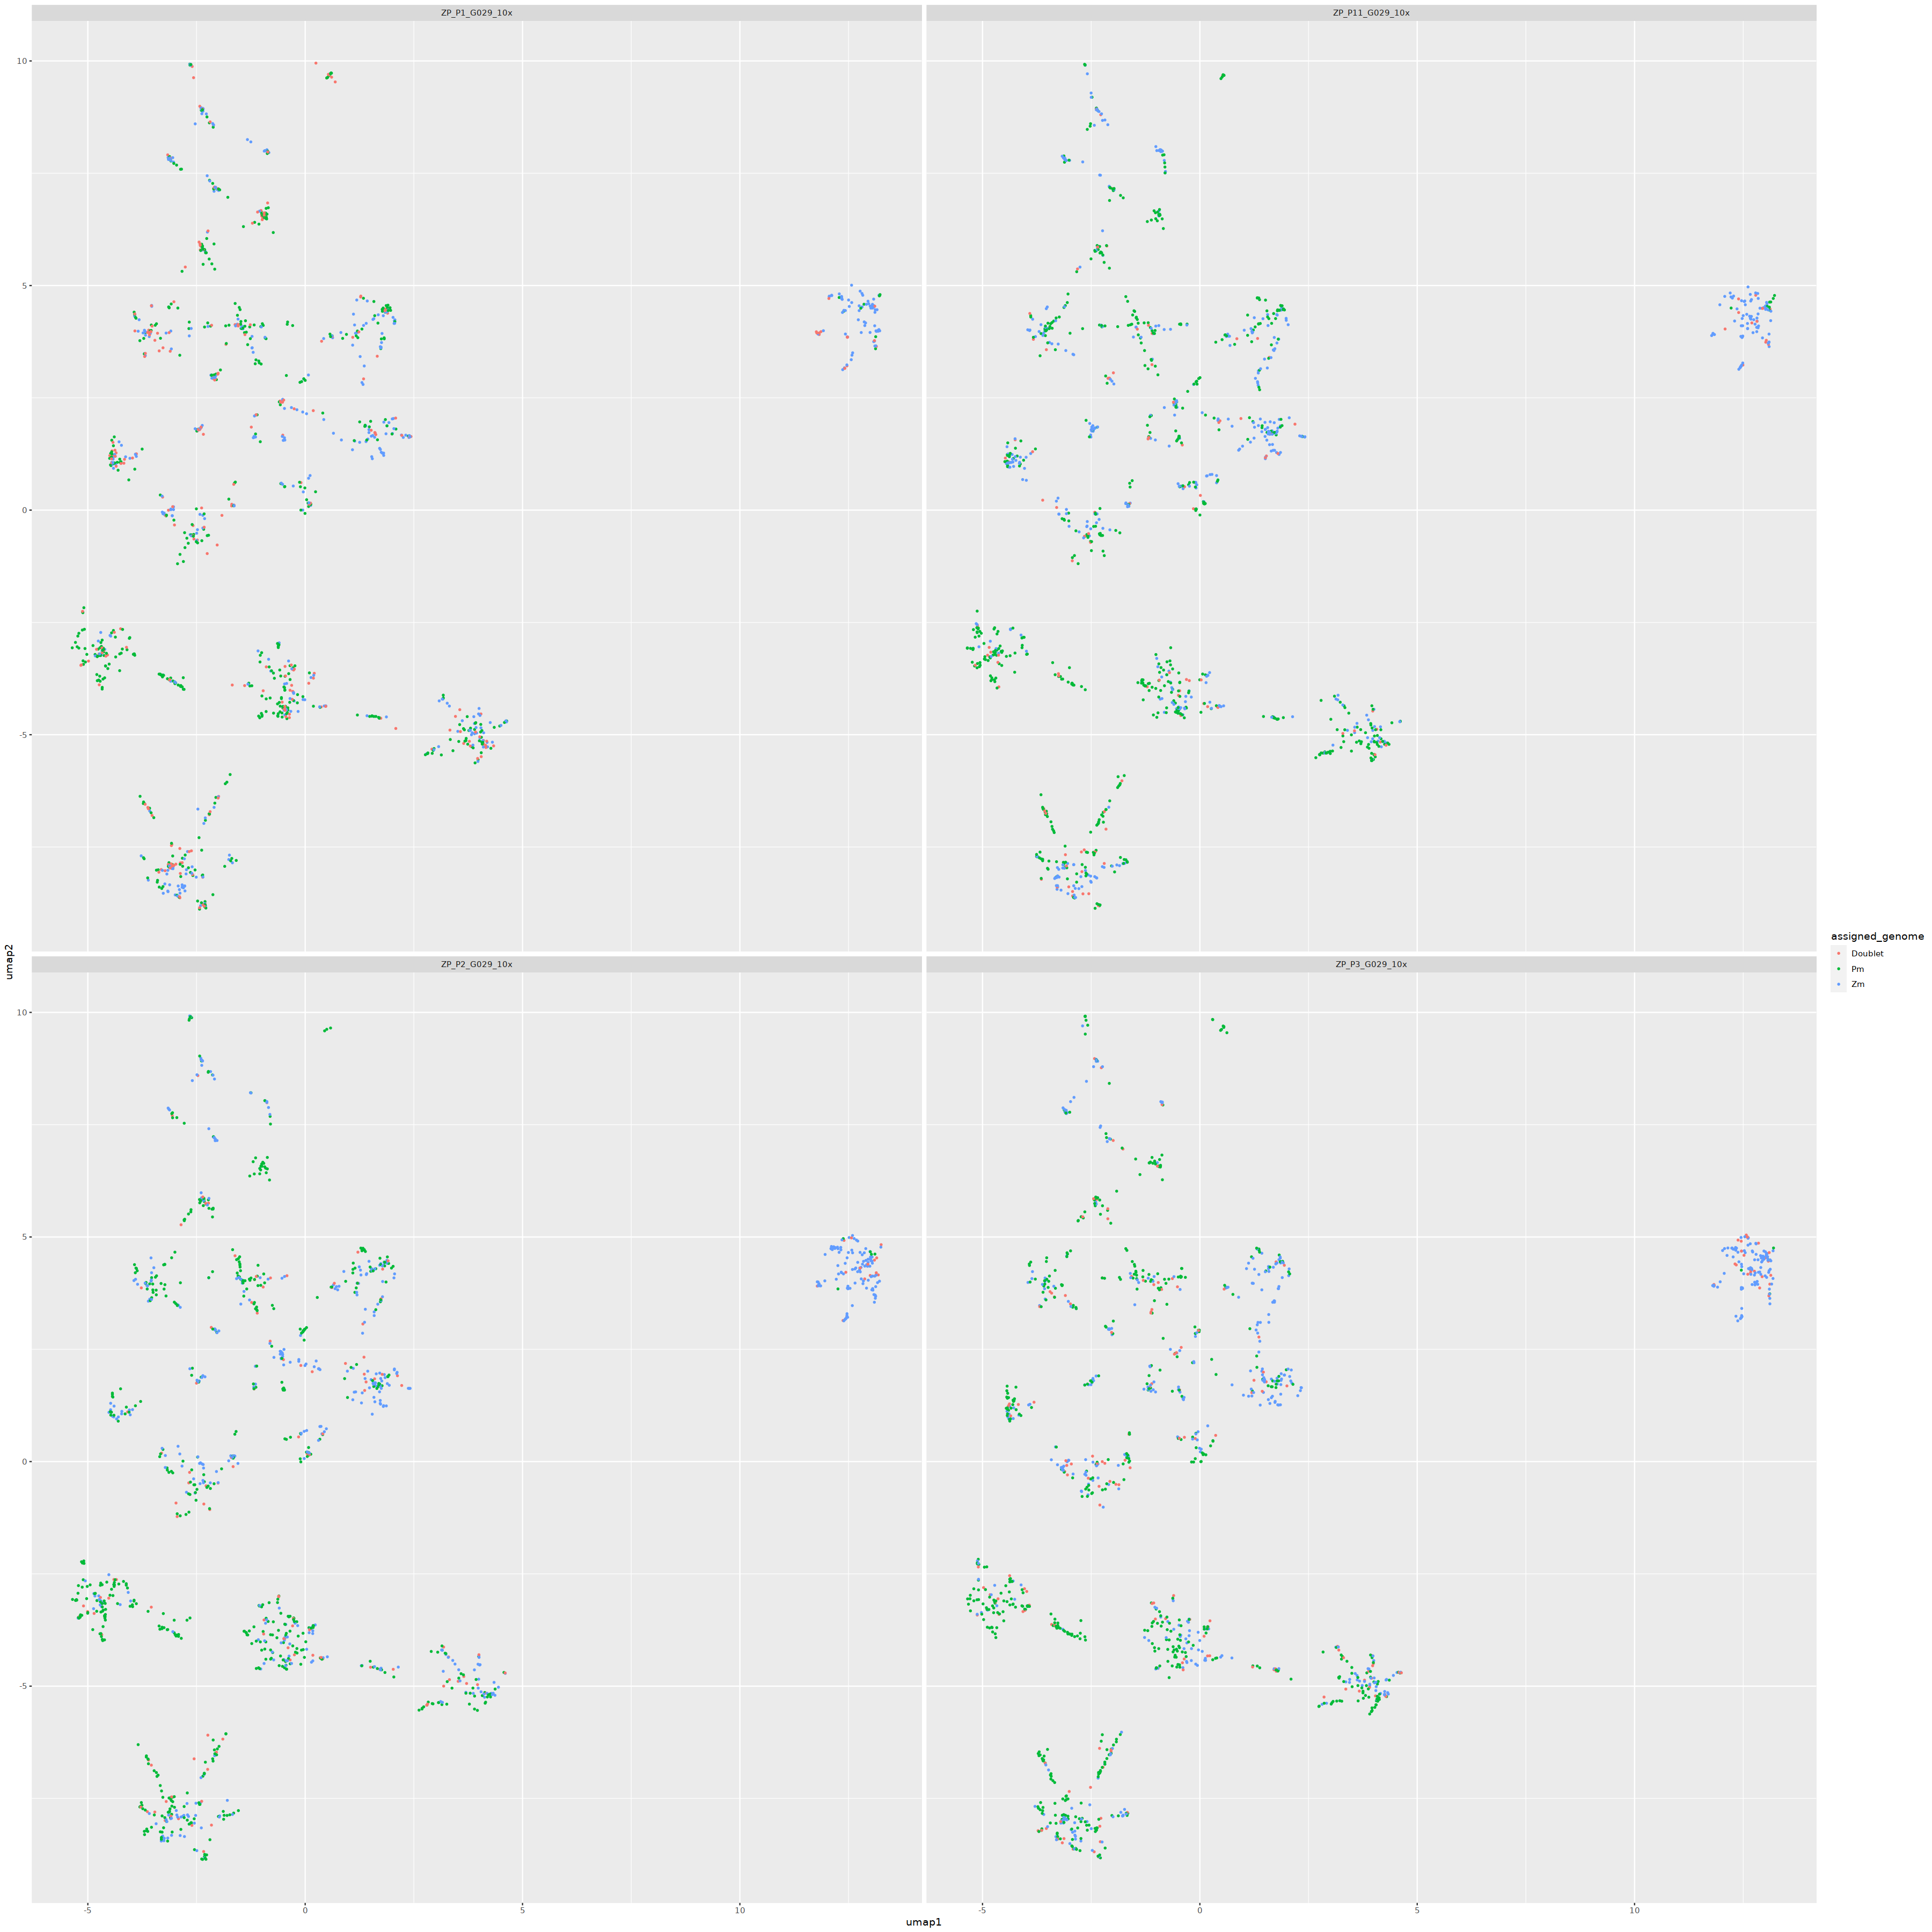

In [38]:
options(repr.plot.width=30, repr.plot.height=30)
ggplot(convert_meta_data, aes(x = umap1, y = umap2, color = assigned_genome)) + 
geom_jitter(size =.5) + facet_wrap(.~plate)

In [24]:
convert_meta_data  %>% 
    group_by(assigned_genome, plate)  %>% 
    summarise(counts = n())

`summarise()` has grouped output by 'assigned_genome'. You can override using the `.groups` argument.



assigned_genome,plate,counts
<chr>,<chr>,<int>
Doublet,ZP_P1_G029_10x,297
Doublet,ZP_P11_G029_10x,123
Doublet,ZP_P2_G029_10x,147
Doublet,ZP_P3_G029_10x,180
Pm,ZP_P1_G029_10x,583
Pm,ZP_P11_G029_10x,647
Pm,ZP_P2_G029_10x,638
Pm,ZP_P3_G029_10x,629
Zm,ZP_P1_G029_10x,448


In [ ]:

# project with NMF -------------------------------------------------------
soc.obj.reduce_dim.svd <- reduceDims(soc.obj,
                      method="SVD", 
                      n.pcs=25, 
                      svd_slotName="SVD")


# reduce to 2-dimensions with UMAP ---------------------------------------
soc.obj.project_umap.svd <- projectUMAP(soc.obj.reduce_dim.svd, 
                       verbose=T,
                       k.near=25,
                       m.dist=0.01,
                       svd_slotName="SVD")


In [ ]:
# identify clusters using neighborhood graph -----------------------------
tfidf.svd_object <- callClusters(soc.obj.project_umap.svd, 
                        res=1.7,
                        verbose=T,
                        svd_slotName= "SVD",
                        cleanCluster=T)

In [ ]:
#plot cluster membership on UMAP embedding ------------------------------
options(repr.plot.width=10, repr.plot.height=10)
# NMF
#pdf(paste0(out,".NMF.full.UMAP.clusters.pdf"), width=10, height=10)
plotUMAP(tfidf.svd_object, cex=0.3)
#dev.off()

In [ ]:
library(dplyr)
library(tidyverse)

doublet_file_location <- "/scratch/jpm73279/comparative_single_cell/02.QC_clustering/Zm_proso_repeat/Cell_metrics.zm_proso.tsv"
collision_rate_info <- read_tsv(doublet_file_location, col_names = TRUE)

svd_meta_collision_rate <- as_tibble(tfidf.svd_object$Clusters)  %>% 
    left_join(., collision_rate_info, by = c("cellID" = "V4"))  %>% 
    filter(is.na(assigned_genome) != TRUE)


In [ ]:
options(repr.plot.width=20, repr.plot.height=20)
ggplot(svd_meta_collision_rate, aes(x = umap1, y = umap2, color = assigned_genome)) + 
    geom_jitter(size = .5)

In [ ]:
options(repr.plot.width=20, repr.plot.height=20)
ggplot(svd_meta_collision_rate, aes(x = umap1, y = umap2, color = LouvainClusters)) + 
    geom_jitter(size = .75) + theme_bw()

In [ ]:
options(repr.plot.width=10, repr.plot.height=10)
ggplot(svd_meta_collision_rate, aes(x = umap1, y = umap2, color = assigned_genome)) + 
    geom_jitter(size = .5) + facet_wrap(.~plate)

In [ ]:
options(repr.plot.width=30, repr.plot.height=10)
ggplot(svd_meta_collision_rate, aes(x = umap1, y = umap2, color = assigned_genome)) + 
    geom_jitter(size =.5) + facet_wrap(.~assigned_genome)

In [ ]:
colnames(svd_meta_collision_rate)

In [ ]:
options(repr.plot.width=30, repr.plot.height=10)
ggplot(svd_meta_collision_rate, aes(x = umap1, y = umap2, color = assigned_genome)) + 
    geom_jitter(size =.5) + facet_wrap(.~assigned_genome)

In [ ]:
options(repr.plot.width=30, repr.plot.height=10)
ggplot(svd_meta_collision_rate, aes(x = umap1, y = umap2, fill = total_insertions)) + 
    geom_raster() +
    scale_fill_gradientn(colours = terrain.colors(10))